In [1]:
import xarray as xr
import datetime
import pymannkendall as mk
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# load landcover and anette's landcover! (first normal landcover)
land_cover = xr.open_dataset('/mnt/data7/nfs4/avh_ndvi/sdupuis/ESACCI-LC-L4-LCCS-Map-300m-P1Y-2015-v2.0.7b.nc', engine='netcdf4')

In [3]:
lc = land_cover.sel(lat=slice(72,55), lon=slice(-168,-150))

In [4]:
yearly = xr.open_dataset('output_data/standard_anomalies_yamal_NIGHT_yearly.nc')

In [5]:
lc_downscaled = xr.open_dataset('lc_downscaled.nc', engine='netcdf4')

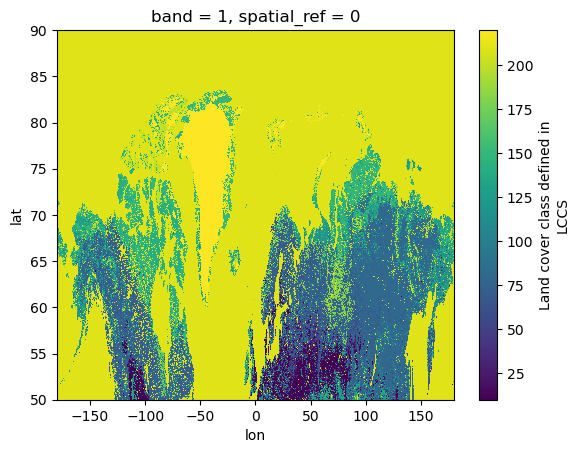

In [6]:
lc_downscaled['lccs_class'].plot();

In [7]:
#lc_interp = land_cover.interp(lat=yearly.coords['lat'], lon=yearly.coords['lon'], method='nearest')

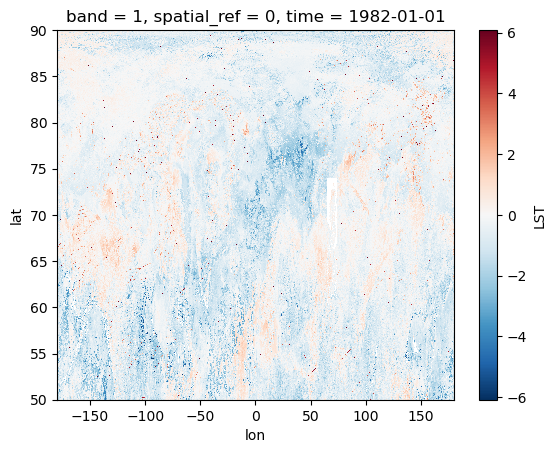

In [8]:
yearly['LST'].isel(time=1).plot();

In [9]:
subset = yearly.sel(lat=slice(55,72), lon=slice(-168,-150), time=slice('1982', '2018'))

In [10]:
yearly = yearly.where(lc_downscaled['lccs_class'] != 210)

In [11]:
# remove 1981 because not complete, verify 1988 and  1998 ! 

In [12]:
yearly_subset = yearly['LST'].sel( time=slice('1982', '2018'))

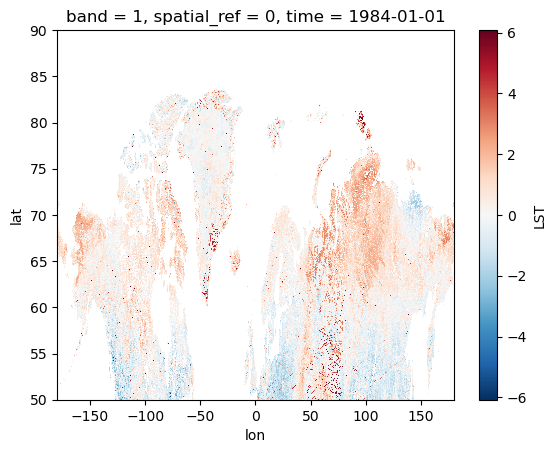

In [13]:
yearly['LST'].isel(time=3).plot();

In [14]:
subset

<xarray.Dataset>
Dimensions:      (lat: 340, lon: 360, time: 37)
Coordinates:
  * lat          (lat) float32 55.03 55.08 55.12 55.17 ... 71.88 71.93 71.97
  * lon          (lon) float32 -168.0 -167.9 -167.9 ... -150.1 -150.1 -150.0
    band         int64 ...
    spatial_ref  int64 ...
  * time         (time) datetime64[ns] 1982-01-01 1983-01-01 ... 2018-01-01
Data variables:
    LST          (lat, lon, time) float32 ...

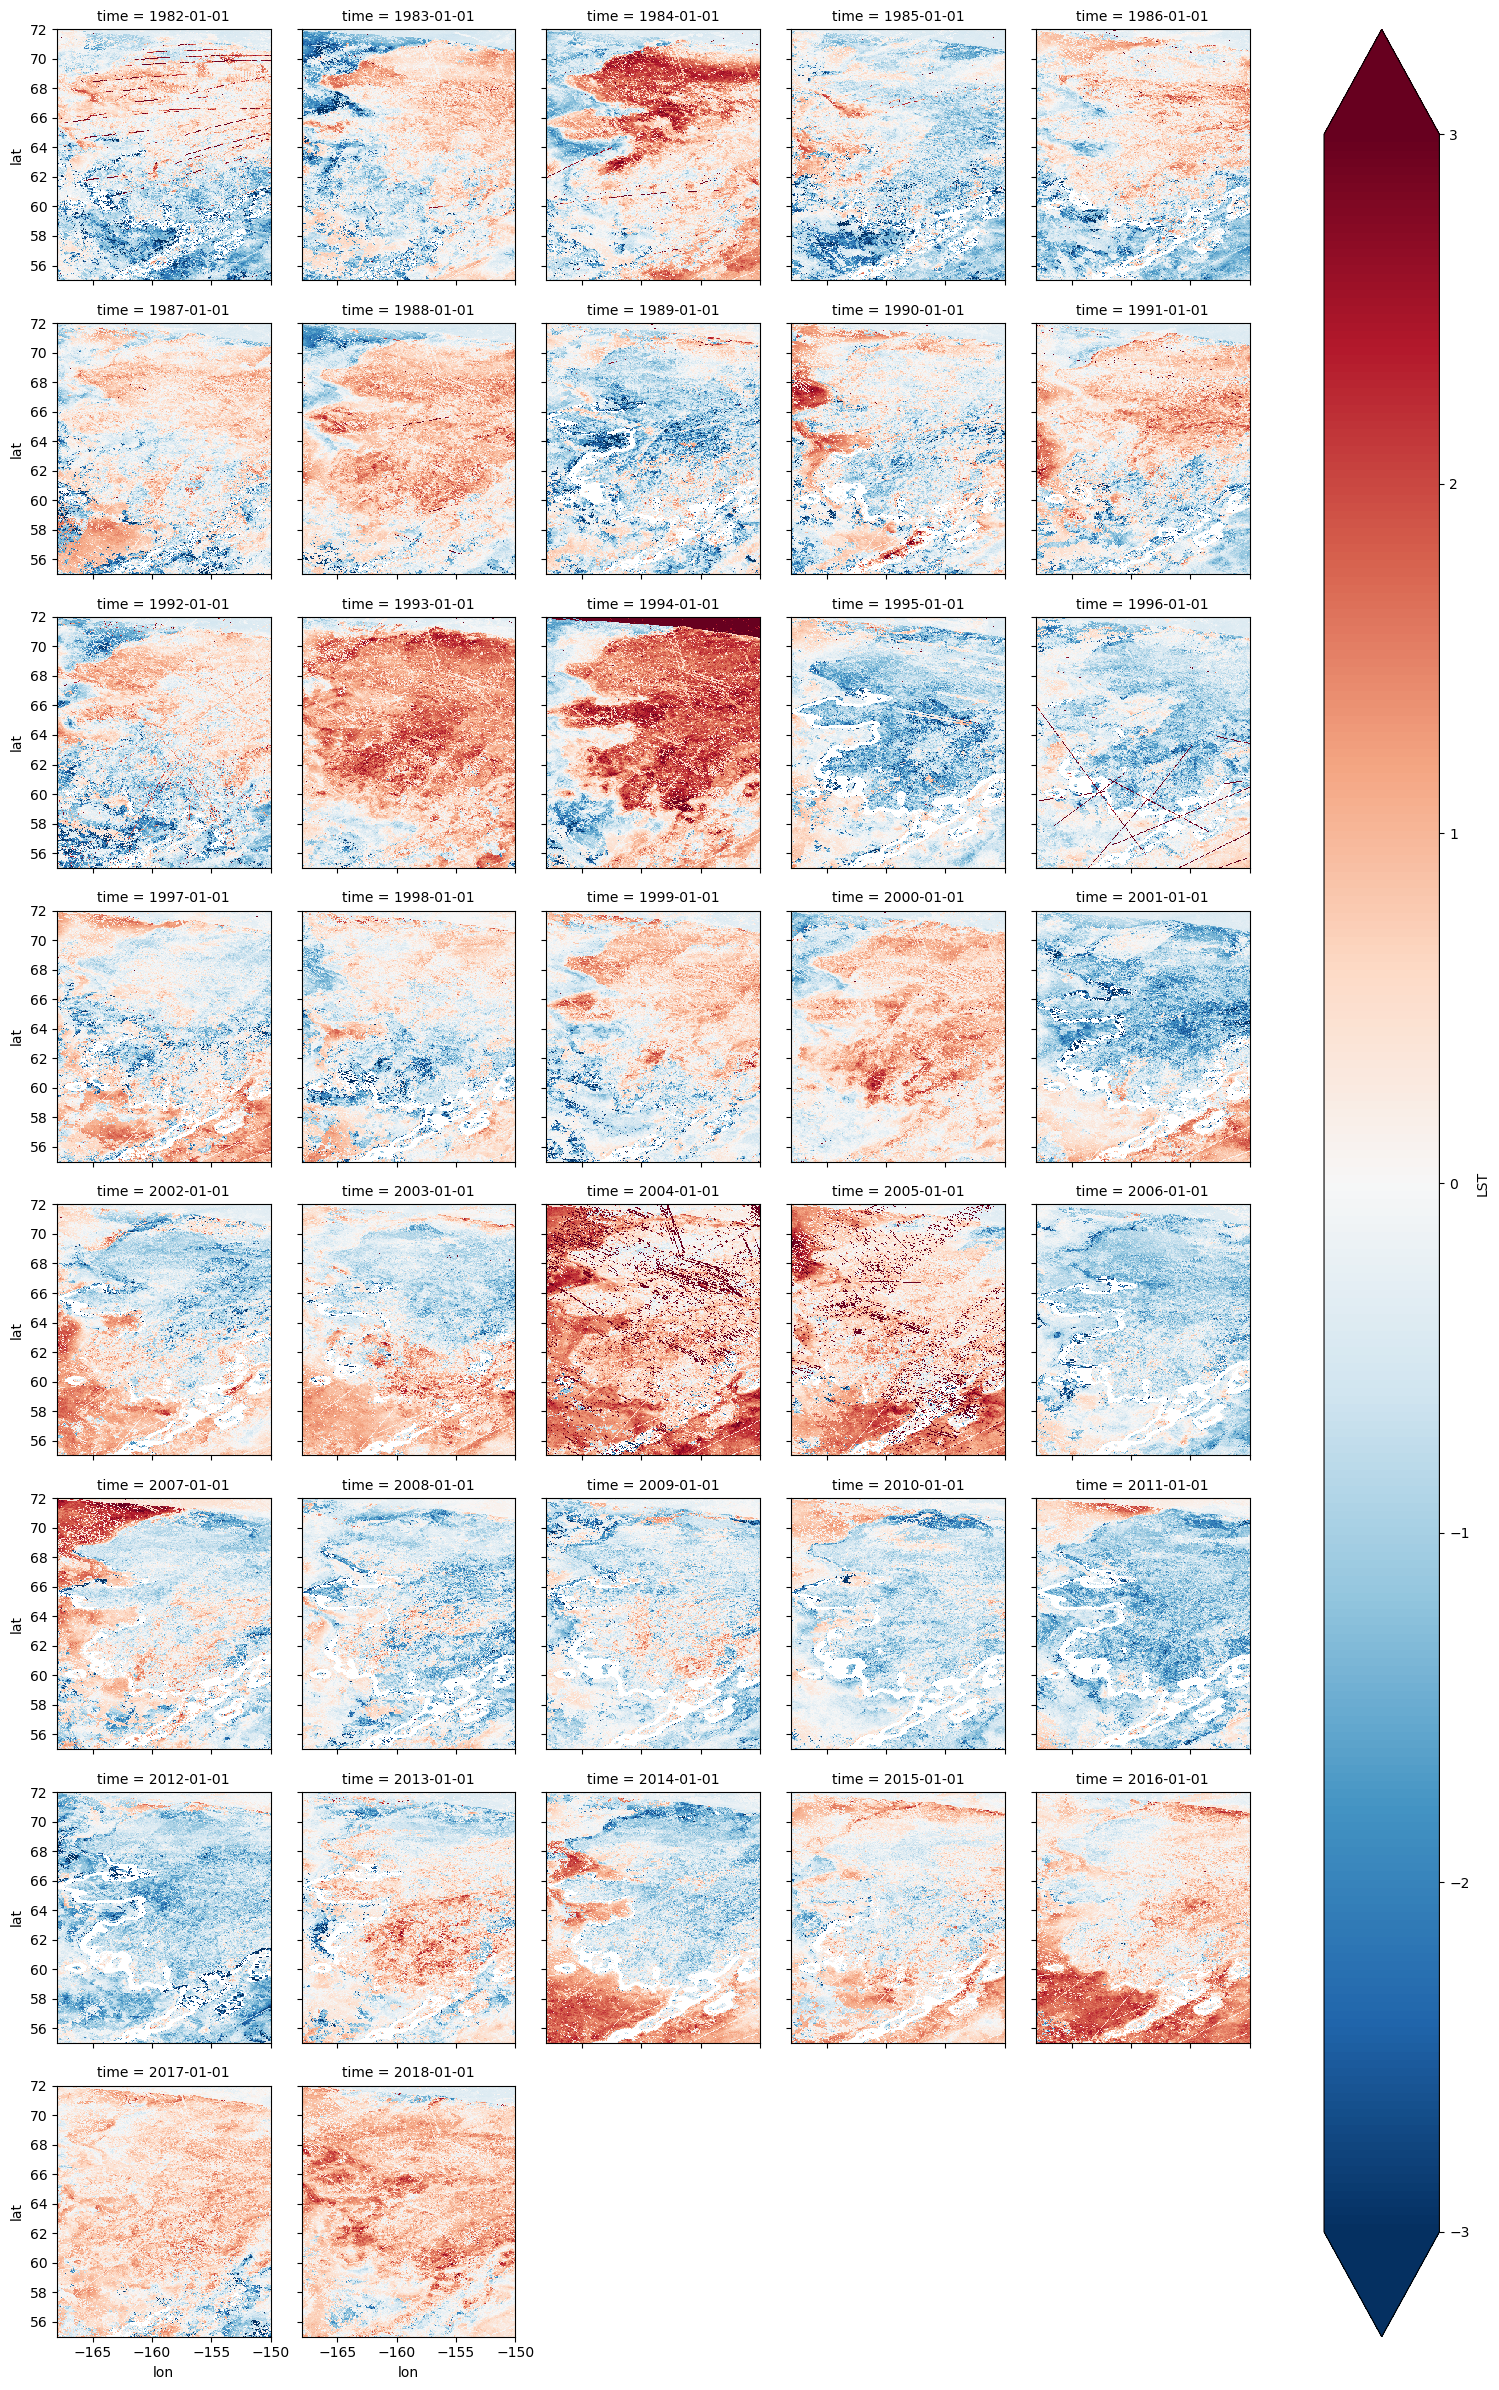

In [15]:
subset['LST'].sel(lat=slice(55,72), lon=slice(-168,-150), time=slice('1981','2018')).plot(x="lon", y="lat", col="time", col_wrap=5, vmax=3);

In [16]:
n_valid = yearly_subset.count(dim="time")

In [17]:
n_valid = n_valid.where(lc_downscaled['lccs_class'] != 210)

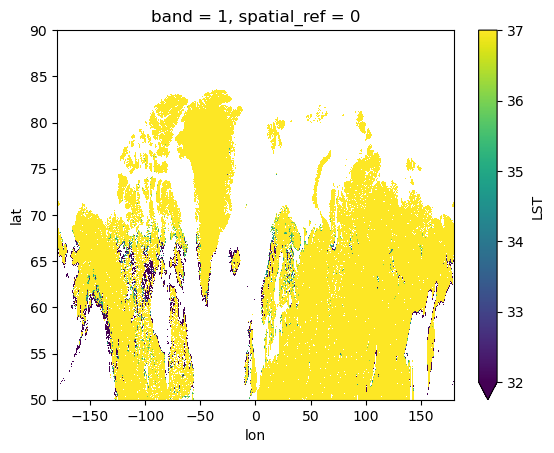

In [18]:
# save as plots
n_valid.plot(vmin=32);

In [19]:
above = ((yearly_subset > 0) & (yearly_subset < 3.0)).sum(dim="time")
below = ((yearly_subset < 0) & (yearly_subset > -3.0)).sum(dim="time")

In [20]:
below = below.where((lc_downscaled['lccs_class'] != 210) & (below!=0))
above = above.where((lc_downscaled['lccs_class'] != 210) & (above!=0))

In [21]:
above_1 = ((yearly_subset > 1) & (yearly_subset < 3.0)).sum(dim="time")
below_minus1 = ((yearly_subset < -1) & (yearly_subset > -3.0)).sum(dim="time")

In [22]:
below_minus1 = below_minus1.where((lc_downscaled['lccs_class'] != 210) & (below_minus1!=0))

In [23]:
above_1 = above_1.where((lc_downscaled['lccs_class'] != 210) & (above_1!=0))

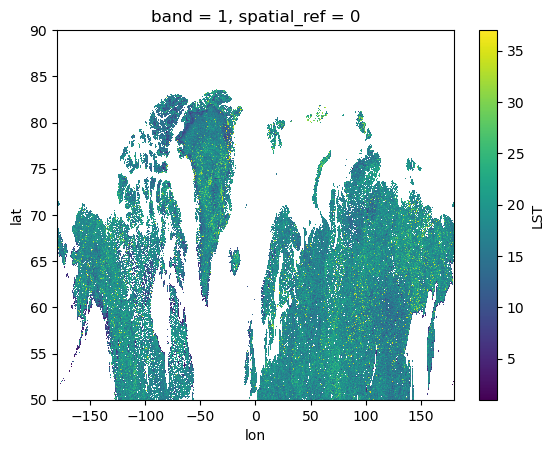

In [24]:
below.plot();

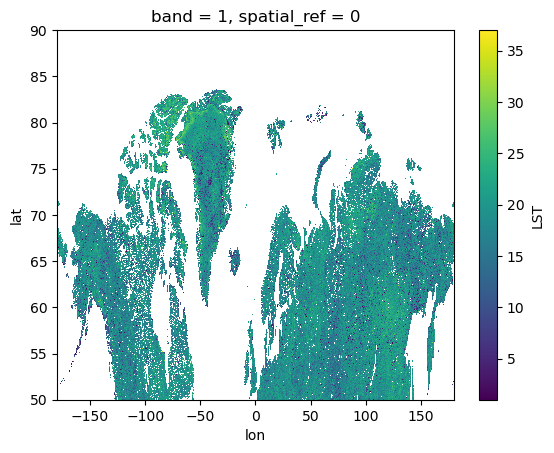

In [25]:
above.plot();

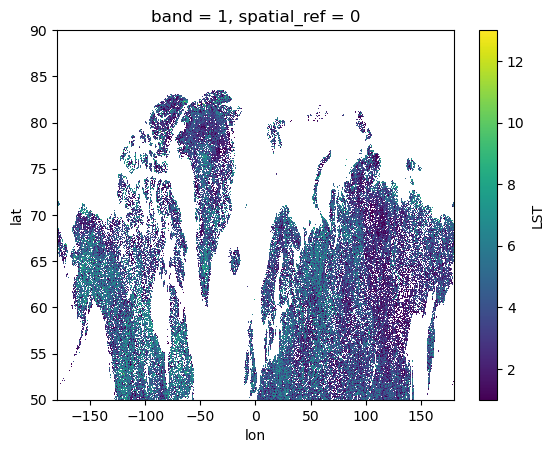

In [26]:
# anomalies above one
below_minus1.plot();

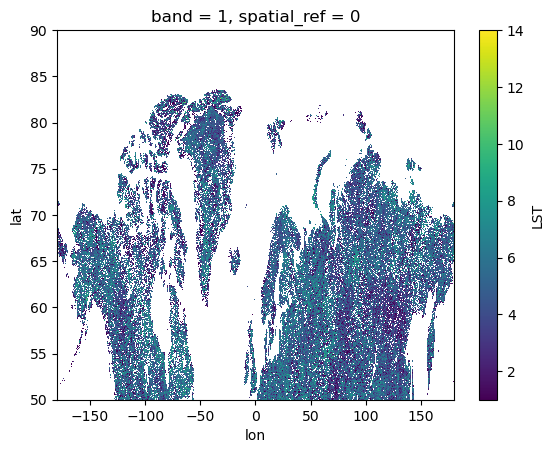

In [27]:
above_1.plot()

In [28]:
lst= yearly_subset

In [29]:
valid_pixels = lst.count(dim=("lat", "lon"))
above_1 = ((lst > 1 )& (lst<3)).sum(dim=("lat", "lon"))
prop_above_1 = above_1 

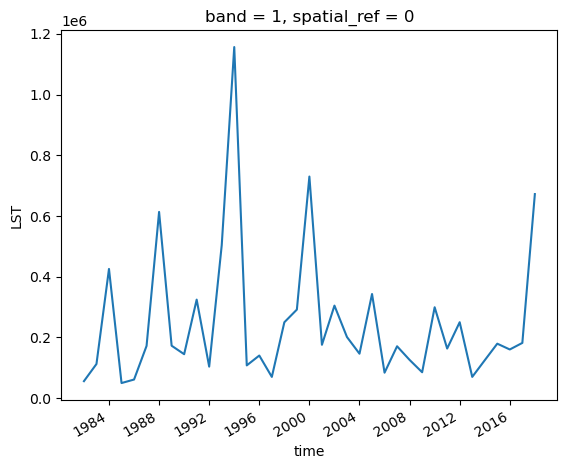

In [30]:
prop_above_1.plot();

In [31]:
import pymannkendall as mk

ts = prop_above_1.dropna(dim="time").values

In [32]:
result = mk.original_test(ts)

In [33]:
result

Mann_Kendall_Test(trend='no trend', h=False, p=0.504757480200261, z=0.6670229404956409, Tau=0.07807807807807808, s=52.0, var_s=5846.0, slope=977.1931818181818, intercept=154704.52272727274)

In [34]:
# link to land cover
def prep_dataset(path):
    ds = xr.open_dataset(path)
    land_cover = xr.open_dataset('lc_downscaled.nc', engine='netcdf4')
    
    subset = ds.sel(lat=slice(lat_tuple[1], lat_tuple[0]), lon=slice(lon_tuple[0], lon_tuple[1]))
    n_valid = subset['LST'].count(dim="time")
    n_valid = n_valid.where(lc_interp['lccs_class'] != 210)
    above_1 = ((subset['LST'] > 1) & (subset['LST'] < 3.0)).sum(dim="time")
    below_minus1 = ((subset['LST'] < -1) & (subset['LST'] > -3.0)).sum(dim="time")
    below_minus1 = below_minus1.where(lc_interp['lccs_class'] != 210)
    above_1 = above_1.where(lc_interp['lccs_class'] != 210)


    return above_1, below_minus1, lc_interp


In [35]:
def map_landcover(df):

    lc_group_map = {
    # 1. Agriculture
    10: "Crop",
    11: "Crop",
    20: "Crop",
    30: "Crop",
    40: "Crop",

    # 2. Forest
    50: "EBF",
    60: "DBF", 61: "DBF", 62: "DBF",
    70: "ENF", 71: "ENF", 72: "ENF",
    80: "DNF", 81: "DNF", 82: "DNF",
    90: "MF",
    100: "MF",
    160: "FF",
    170: "FF",

    # 3. Grassland
    110: "Grass",
    130: "Grass",

    # 4. Wetland
    180: "Wet",

    # 5. Settlement
    190: "Settlement",

    # 6. Other (Shrubland / Sparse / Bare / Water)
    120: "Shrub",
    121: "Shrub",
    122: "Shrub",
    140: "Lichens",
    150: "Sparse",
    151: "Sparse",
    152: "Sparse",
    153: "Sparse",
    200: "Bare",
    201: "Bare",
    202: "Bare",
    220: "Ice"
    }

    df["landcover_group"] = df["landcover"].map(lc_group_map)
    # filter classes with very low samples
    counts = df["landcover_group"].value_counts()
    print(counts)
    valid_classes = counts[counts > 20].index

    df = df[df["landcover_group"].isin(valid_classes)]
    return df


In [36]:
# link to land cover ? Day and Night -> check with air temperature
def df_creation(ds, lc):
    lc_interp = lc
    data = ds.where(~np.isnan(lc_interp['lccs_class']))
    landcover = lc_interp.where(~np.isnan(ds))
    trend_1d = data.stack(points=("lat", "lon"))
    lc_1d = landcover['lccs_class'].stack(points=("lat", "lon"))

    valid = (~np.isnan(trend_1d)) & (~np.isnan(lc_1d))
    trend_1d = trend_1d[valid]
    lc_1d = lc_1d[valid]
    df = pd.DataFrame({
    "trend": trend_1d.values,
    "landcover": lc_1d.values.astype(int)
    })

    df_filtered = map_landcover(df)
    return df_filtered


In [37]:
above_anoms_d, below_anoms_d, land_cov = prep_dataset('output_data/standard_anomalies_yamal_day_yearly.nc')

ValueError: did not find a match in any of xarray's currently installed IO backends ['netcdf4', 'scipy', 'rasterio']. Consider explicitly selecting one of the installed engines via the ``engine`` parameter, or installing additional IO dependencies, see:
https://docs.xarray.dev/en/stable/getting-started-guide/installing.html
https://docs.xarray.dev/en/stable/user-guide/io.html

In [ ]:
anom_df_above1_d = df_creation(above_anoms_d, land_cov)

landcover_group
Shrub         16439
Grass         10863
ENF           10262
Sparse         9400
MF             6907
Lichens        4150
Bare           2844
Wet            1741
FF             1056
DBF             924
Ice             821
DNF             552
Crop              5
Settlement        1
Name: count, dtype: int64


In [ ]:
anom_df_below_d = df_creation(below_anoms_d, land_cov)

landcover_group
Shrub         16439
Grass         10863
ENF           10262
Sparse         9400
MF             6907
Lichens        4150
Bare           2844
Wet            1741
FF             1056
DBF             924
Ice             821
DNF             552
Crop              5
Settlement        1
Name: count, dtype: int64


In [ ]:
result_anoms_alaska

Datasets  trend  landcover landcover_group
0      Day_positive    2.0        120           Shrub
1      Day_positive    2.0        120           Shrub
2      Day_positive    3.0        130           Grass
3      Day_positive    4.0        120           Shrub
4      Day_positive    4.0        120           Shrub
...             ...    ...        ...             ...
65960  Day_negative    2.0        180             Wet
65961  Day_negative    5.0        140         Lichens
65962  Day_negative    1.0        140         Lichens
65963  Day_negative    1.0        140         Lichens
65964  Day_negative    1.0        180             Wet

[131918 rows x 4 columns]

In [ ]:
anom_df_above1_d = df_creation(above_anoms_d, land_cov)
anom_df_below_d = df_creation(below_anoms_d, land_cov)
result_anoms_alaska = (
    pd.concat(
        [anom_df_above1_d, anom_df_below_d],
        keys=["Day_positive", "Day_negative"],
        names=["Datasets"]
    )
    .reset_index(level="Datasets")
)

landcover_group
Shrub         16439
Grass         10863
ENF           10262
Sparse         9400
MF             6907
Lichens        4150
Bare           2844
Wet            1741
FF             1056
DBF             924
Ice             821
DNF             552
Crop              5
Settlement        1
Name: count, dtype: int64
landcover_group
Shrub         16439
Grass         10863
ENF           10262
Sparse         9400
MF             6907
Lichens        4150
Bare           2844
Wet            1741
FF             1056
DBF             924
Ice             821
DNF             552
Crop              5
Settlement        1
Name: count, dtype: int64


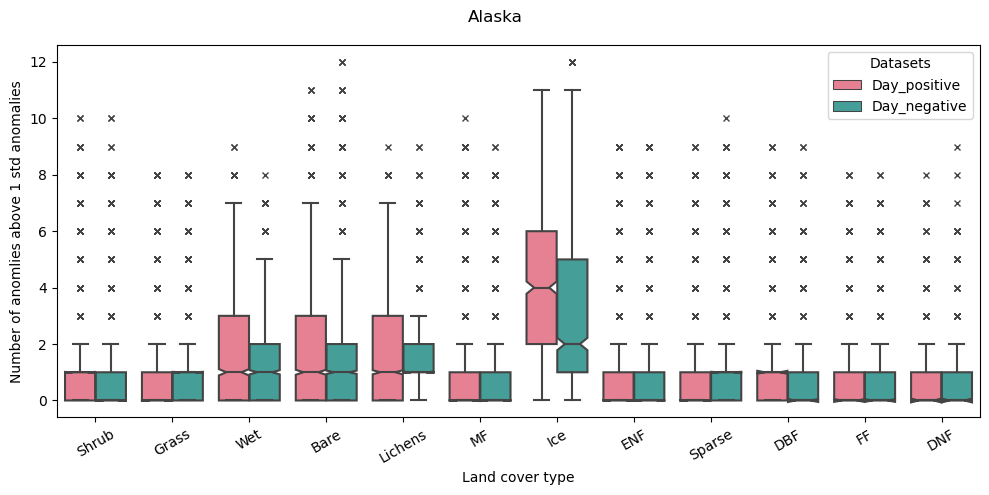

In [ ]:
# Group all boxplots
plt.figure(figsize=(10, 5))
sns.boxplot(
    data=result_anoms_alaska,
    x="landcover_group",   # or "landcover"
    y="trend",
    hue='Datasets',
    palette = 'husl',
    notch=True,
    flierprops={"marker":"x"}
)

plt.ylabel("Number of anomlies above 1 std anomalies")
plt.xlabel("Land cover type")
plt.suptitle('Alaska')
plt.xticks(rotation=30)
plt.tight_layout()
#plt.savefig('Alaska_box_plot_anomalies.png')
plt.show()

In [ ]:
# koppen geiger zones


In [ ]:
# SWE march trends and SSL

In [ ]:
# Link to DEM